## Classifying between 6 and 4
## Using amplitude encoding (9x9)

In [1]:
import pennylane as qml
import tensorflow as tf
#import sklearn.datasets
#from sklearn.datasets import fetch_openml

import numpy as np

from matplotlib import pyplot as plt

tf.keras.backend.set_floatx('float64')

from silence_tensorflow import silence_tensorflow
silence_tensorflow()  # this stops tensorflow complaining about converting from complex to float!

from datetime import datetime

## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Create a function to filter out only 0 and 2

In [3]:
def filter_64(x, y):
    keep = (y == 6) | (y == 4)
    x, y = x[keep], y[keep]
    y = y == 0
    return x,y

In [4]:
x_train, y_train = filter_64(x_train, y_train)
x_test, y_test = filter_64(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 11760
Number of filtered test examples: 1940


Plot the original images

In [5]:
i = 0

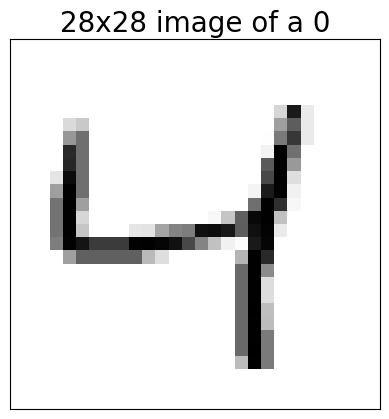

In [6]:
i += 1
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('28x28_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Reduce images to 9x9

In [7]:
x_train_small = tf.image.resize(x_train, (9,9)).numpy()
x_test_small = tf.image.resize(x_test, (9,9)).numpy()

print(x_train_small.shape)

(11760, 9, 9, 1)


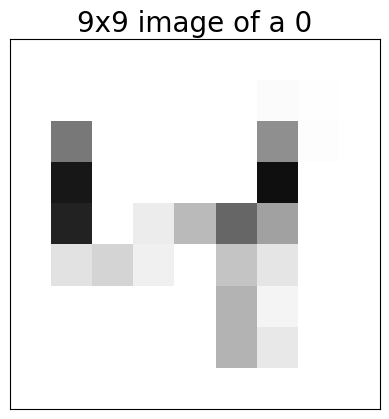

In [8]:
plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("9x9 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('9x9_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Flatten the images to [81]

In [9]:
x_train_flatten = x_train_small.reshape(x_train_small.shape[0], x_train_small.shape[1] * x_train_small.shape[2])
x_test_flatten = x_test_small.reshape(x_test_small.shape[0], x_test_small.shape[1] * x_test_small.shape[2])
x_train_flatten.shape, x_test_flatten.shape

((11760, 81), (1940, 81))

## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then conver this to a Keras layer to make a Keras model

In [10]:
n_qubits = int(np.ceil(np.log2(x_train_flatten.shape[-1])))
n_layers = 1

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):
    
    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0., normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(x_train_flatten.shape[-1],), name="inputs")
outputs = qlayer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model.predict(x_train_flatten[0, :])
print(model.summary())

3/3 [==============================] - 0s 73ms/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 81)]              0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 39        
                                                                 
Total params: 39 (312.00 Byte)
Trainable params: 39 (312.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Redefine the classification values to match the Hinge loss

In [11]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Define the hinge accuracy

In [12]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

## Compile and train the model

Compile the model using the hinge loss and accuracy and the Adam optimiser

In [13]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [14]:
print(model.summary())

Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 81)]              0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 39        
                                                                 
Total params: 39 (312.00 Byte)
Trainable params: 39 (312.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Train the model over 20 epochs

In [15]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 
print(f"x shape = {x_train_flatten.shape}")
print(NUM_EXAMPLES)

x_train_sub = x_train_flatten[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

print(f"x train shape = {x_train_sub.shape}")

x_test_sub = x_test_flatten[:,:]
y_test_sub = y_test[:]

print(f"x test shape = {x_test_sub.shape}")

start_time = datetime.now()

qnn_history_1layer = model.fit(
      x_train_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

model_training_time = datetime.now() - start_time

qnn_results_1layer = model.evaluate(x_test_sub, y_test_sub)



x shape = (11760, 81)
512
x train shape = (512, 81)
x test shape = (1940, 81)
Epoch 1/20
16/16 [==============================] - 3s 207ms/step - loss: 1.1166 - hinge_accuracy: 0.2051
Epoch 2/20
16/16 [==============================] - 3s 208ms/step - loss: 1.0919 - hinge_accuracy: 0.2539
Epoch 3/20
16/16 [==============================] - 3s 212ms/step - loss: 1.0675 - hinge_accuracy: 0.3262
Epoch 4/20
16/16 [==============================] - 3s 199ms/step - loss: 1.0440 - hinge_accuracy: 0.4023
Epoch 5/20
16/16 [==============================] - 3s 201ms/step - loss: 1.0209 - hinge_accuracy: 0.4668
Epoch 6/20
16/16 [==============================] - 3s 195ms/step - loss: 0.9986 - hinge_accuracy: 0.5176
Epoch 7/20
16/16 [==============================] - 3s 195ms/step - loss: 0.9764 - hinge_accuracy: 0.5840
Epoch 8/20
16/16 [==============================] - 3s 192ms/step - loss: 0.9552 - hinge_accuracy: 0.6289
Epoch 9/20
16/16 [==============================] - 3s 192ms/step - loss: 

Create and train a 2 layer version of the QNN

In [16]:
n_qubits = int(np.ceil(np.log2(x_train_flatten.shape[-1])))
n_layers = 2

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="tf")
def qnode(inputs, weights):

    qml.AmplitudeEmbedding(features=inputs, wires=range(n_qubits), pad_with=0., normalize=True)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(x_train_flatten.shape[-1],), name="inputs")
outputs = qlayer(inputs)
model2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2.predict(x_train_flatten[0,:])
print(model2.summary())

3/3 [==============================] - 0s 125ms/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 81)]              0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 78        
                                                                 
Total params: 78 (624.00 Byte)
Trainable params: 78 (624.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [17]:
model2.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [18]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_flatten[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_flatten[:,:]
y_test_sub = y_test[:]

start_time = datetime.now()

qnn_history_2layer = model2.fit(
      x_train_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1)#,
      #validation_data=(x_test_sub, y_test_sub))

model2_training_time = datetime.now() - start_time

qnn_results_2layer = model2.evaluate(x_test_sub, y_test_sub)

512
Epoch 1/20
16/16 [==============================] - 6s 364ms/step - loss: 1.5722 - hinge_accuracy: 0.0000e+00
Epoch 2/20
16/16 [==============================] - 6s 364ms/step - loss: 1.5180 - hinge_accuracy: 0.0000e+00
Epoch 3/20
16/16 [==============================] - 6s 365ms/step - loss: 1.4533 - hinge_accuracy: 0.0000e+00
Epoch 4/20
16/16 [==============================] - 6s 359ms/step - loss: 1.3764 - hinge_accuracy: 0.0000e+00
Epoch 5/20
16/16 [==============================] - 6s 363ms/step - loss: 1.2878 - hinge_accuracy: 0.0000e+00
Epoch 6/20
16/16 [==============================] - 6s 373ms/step - loss: 1.1929 - hinge_accuracy: 0.0176
Epoch 7/20
16/16 [==============================] - 6s 362ms/step - loss: 1.0971 - hinge_accuracy: 0.1504
Epoch 8/20
16/16 [==============================] - 6s 365ms/step - loss: 1.0069 - hinge_accuracy: 0.4629
Epoch 9/20
16/16 [==============================] - 6s 367ms/step - loss: 0.9274 - hinge_accuracy: 0.7656
Epoch 10/20
16/16 [===

## Plot the results!

In [26]:
print(f"1-layer model training time: {model_training_time}")
print(f"2-layer model training time: {model2_training_time}")

1-layer model training time: 0:01:03.007642
2-layer model training time: 0:01:56.676328


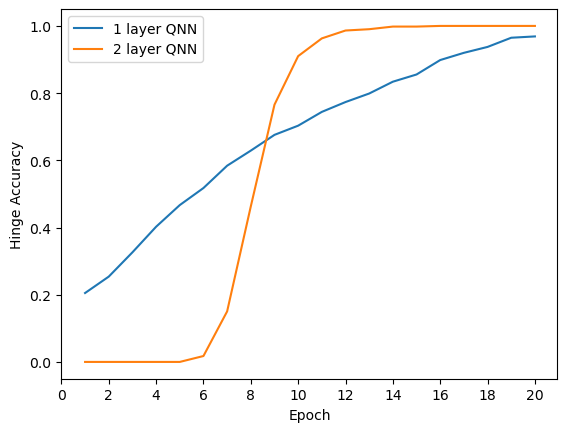

In [20]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["hinge_accuracy"], label="1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["hinge_accuracy"], label="2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2))
# save as pdf with tight layout and no padding
#plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

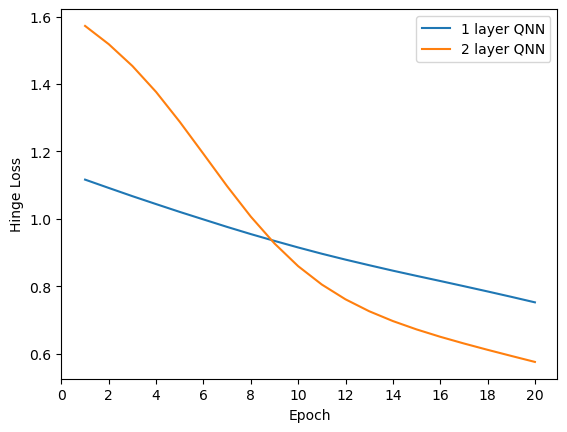

In [21]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["loss"], label="1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["loss"], label="2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2))
# save as pdf with tight layout and no padding
#plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()